In [20]:
# pyrates imports
from pyrates.ir.circuit import CircuitIR
from pyrates.backend import ComputeGraph
from pyrates.utility import plot_connectivity
from pyrates.frontend import CircuitTemplate

# additional imports
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['legend.fontsize'] = 20
from seaborn import cubehelix_palette
from copy import deepcopy
import time

In [21]:
# parameter definitions
dt = 1e-3
T = 1.0
c = 20.
n_jrcs =[1, 2, 4, 8, 16, 32, 64, 128, 256, 512][::-1]
p_conn = [0.81, 0.27, 0.09, 0.03, 0.01][::-1]
sim_times = np.zeros((len(n_jrcs), len(p_conn), 4))

In [22]:
def benchmark(Ns, Ps, T, dt, init_kwargs, run_kwargs):
    """

    Parameters
    ----------
    Ns
    Ps
    T
    dt
    init_kwargs
    run_kwargs

    Returns
    -------

    """

    times = np.zeros((len(Ns), len(Ps)))
    peak_mem = np.zeros_like(times)

    for i, n in enumerate(Ns):
        for j, p in enumerate(Ps):

            print(f'Running benchmark for n = {n} and p = {p}.')

            # define inter-JRC connectivity
            print('connectivity setup')
            t0 = time.time()
            C = np.random.uniform(size=(n, n))
            C[C > p] = 0.
            conns = DataFrame(C, columns=[f'jrc_{idx}/PC.0/PRO.0/m_out' for idx in range(n)])
            conns.index = [f'jrc_{idx}/PC.0/RPO_e_pc.0/m_in' for idx in range(n)]
            print(f'...finished after {time.time() - t0} seconds.')

            # define input
            inp = 220 + np.random.randn(int(T / dt), n) * 22.

            # set up template
            print('Frontend template setup')
            t0 = time.time()
            template = CircuitTemplate.from_yaml("pyrates.examples.jansen_rit.simple_jr.JRC")
            print(f'...finished after {time.time() - t0} seconds.')

            # set up intermediate representation
            print('IR setup')
            t0 = time.time()
            circuits = {}
            for idx in range(n):
                circuits[f'jrc_{idx}'] = deepcopy(template)
            circuit = CircuitIR.from_circuits(label='net', circuits=circuits, connectivity=conns)
            print(f'...finished after {time.time() - t0} seconds.')

            # set up compute graph
            print('Compute graph setup')
            t0 = time.time()
            net = ComputeGraph(circuit, dt=dt, **init_kwargs)
            print(f'...finished after {time.time() - t0} seconds.')

            # run simulations
            _, t, m = net.run(T, inputs={('PC', 'RPO_e_pc.0', 'u'): inp}, outputs={'V': ('PC', 'PRO.0', 'PSP')},
                              verbose=False, **run_kwargs)
            times[i, j] = t
            peak_mem[i, j] = m

    return times, peak_mem

In [8]:
# pyrates simulation
t, _ = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'nodes'}, run_kwargs={'profile': 't'})
sim_times[:, :, 0] = t
t, _ = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'full'}, run_kwargs={'profile': 't'})
sim_times[:, :, 1] = t
_, m = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'nodes'}, run_kwargs={'profile': 'm'})
sim_times[:, :, 2] = m
_, m = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'full'}, run_kwargs={'profile': 'm'})
sim_times[:, :, 3] = m

Running benchmark for n = 1 and p = 0.81.
connectivity setup
...finished after 0.001924276351928711 seconds.
Frontend template setup
...finished after 0.21952080726623535 seconds.
IR setup
...finished after 0.0065538883209228516 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.005456209182739258 seconds.
...finished after 0.5263478755950928 seconds.
Running benchmark for n = 1 and p = 0.27.
connectivity setup
...finished after 0.0006425380706787109 seconds.
Frontend template setup
...finished after 5.745887756347656e-05 seconds.
IR setup
...finished after 0.0035254955291748047 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.0025453567504882812 seconds.
...finished after 0.44646501541137695 seconds.
Running benchmark for n = 1 and p = 0.09.
connectivity setup
...finished after 0.000609397888183593

...finished after 0.5323550701141357 seconds.
Running benchmark for n = 8 and p = 0.01.
connectivity setup
...finished after 0.000606536865234375 seconds.
Frontend template setup
...finished after 3.170967102050781e-05 seconds.
IR setup
...finished after 0.026512861251831055 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.01733112335205078 seconds.
...finished after 0.5301847457885742 seconds.
Running benchmark for n = 16 and p = 0.81.
connectivity setup
...finished after 0.0008726119995117188 seconds.
Frontend template setup
...finished after 3.4332275390625e-05 seconds.
IR setup
...finished after 0.0585935115814209 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.04555916786193848 seconds.
...finished after 0.4981381893157959 seconds.
Running benchmark for n = 16 and p = 0.27.
connectivity setu

...finished after 0.5185806751251221 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 1.1291542053222656 seconds.
...finished after 1.6390960216522217 seconds.
Running benchmark for n = 128 and p = 0.03.
connectivity setup
...finished after 0.0009326934814453125 seconds.
Frontend template setup
...finished after 3.528594970703125e-05 seconds.
IR setup
...finished after 0.49583935737609863 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 1.091524600982666 seconds.
...finished after 1.5924913883209229 seconds.
Running benchmark for n = 128 and p = 0.01.
connectivity setup
...finished after 0.0009779930114746094 seconds.
Frontend template setup
...finished after 3.409385681152344e-05 seconds.
IR setup
...finished after 0.4854106903076172 seconds.
Compute graph setup
moving edge operators to nodes...
chec

...finished after 0.3529484272003174 seconds.
Running benchmark for n = 2 and p = 0.27.
connectivity setup
...finished after 0.0005385875701904297 seconds.
Frontend template setup
...finished after 3.24249267578125e-05 seconds.
IR setup
...finished after 0.0070247650146484375 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.0066225528717041016 seconds.
...finished after 0.4344508647918701 seconds.
Running benchmark for n = 2 and p = 0.09.
connectivity setup
...finished after 0.0006053447723388672 seconds.
Frontend template setup
...finished after 3.9577484130859375e-05 seconds.
IR setup
...finished after 0.007169246673583984 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.006306886672973633 seconds.
...finished after 0.35631656646728516 seconds.
Running benchmark for n = 2 and p = 0.03.
connectiv

...finished after 0.40889716148376465 seconds.
Running benchmark for n = 32 and p = 0.81.
connectivity setup
...finished after 0.0008518695831298828 seconds.
Frontend template setup
...finished after 4.315376281738281e-05 seconds.
IR setup
...finished after 0.19435477256774902 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.15002727508544922 seconds.
...finished after 0.5178244113922119 seconds.
Running benchmark for n = 32 and p = 0.27.
connectivity setup
...finished after 0.0008687973022460938 seconds.
Frontend template setup
...finished after 4.3392181396484375e-05 seconds.
IR setup
...finished after 0.1113135814666748 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.12897443771362305 seconds.
...finished after 0.5544180870056152 seconds.
Running benchmark for n = 32 and p = 0.09.
connectivity

...finished after 0.9377725124359131 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 4.626343488693237 seconds.
...finished after 5.1798341274261475 seconds.
Running benchmark for n = 256 and p = 0.01.
connectivity setup
...finished after 0.0015995502471923828 seconds.
Frontend template setup
...finished after 6.771087646484375e-05 seconds.
IR setup
...finished after 0.8470642566680908 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 4.558730840682983 seconds.
...finished after 5.078840494155884 seconds.
Running benchmark for n = 512 and p = 0.81.
connectivity setup
...finished after 0.004603385925292969 seconds.
Frontend template setup
...finished after 5.817413330078125e-05 seconds.
IR setup
...finished after 6.811643600463867 seconds.
Compute graph setup
moving edge operators to nodes...
checking 

...finished after 0.5277831554412842 seconds.
Running benchmark for n = 4 and p = 0.09.
connectivity setup
...finished after 0.0005424022674560547 seconds.
Frontend template setup
...finished after 4.076957702636719e-05 seconds.
IR setup
...finished after 0.013275861740112305 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.008415699005126953 seconds.
...finished after 0.3953211307525635 seconds.
Running benchmark for n = 4 and p = 0.03.
connectivity setup
...finished after 0.001010894775390625 seconds.
Frontend template setup
...finished after 6.0558319091796875e-05 seconds.
IR setup
...finished after 0.013774633407592773 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.008811235427856445 seconds.
...finished after 0.5498731136322021 seconds.
Running benchmark for n = 4 and p = 0.01.
connectivity

...finished after 0.2839791774749756 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.42178869247436523 seconds.
...finished after 1.0018846988677979 seconds.
Running benchmark for n = 64 and p = 0.27.
connectivity setup
...finished after 0.0008952617645263672 seconds.
Frontend template setup
...finished after 4.1961669921875e-05 seconds.
IR setup
...finished after 0.24019742012023926 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.36257266998291016 seconds.
...finished after 0.919677734375 seconds.
Running benchmark for n = 64 and p = 0.09.
connectivity setup
...finished after 0.0007603168487548828 seconds.
Frontend template setup
...finished after 3.4332275390625e-05 seconds.
IR setup
...finished after 0.21434473991394043 seconds.
Compute graph setup
moving edge operators to nodes...
checking n

...finished after 15.487608671188354 seconds.
Running benchmark for n = 512 and p = 0.01.
connectivity setup
...finished after 0.004046440124511719 seconds.
Frontend template setup
...finished after 5.245208740234375e-05 seconds.
IR setup
...finished after 1.8030803203582764 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 14.615392446517944 seconds.
...finished after 15.294193983078003 seconds.
Running benchmark for n = 1 and p = 0.81.
connectivity setup
...finished after 0.0006041526794433594 seconds.
Frontend template setup
...finished after 3.8623809814453125e-05 seconds.
IR setup
...finished after 0.0036182403564453125 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.0040700435638427734 seconds.
...finished after 0.3544478416442871 seconds.
Running benchmark for n = 1 and p = 0.27.
connectivity

...finished after 0.4430520534515381 seconds.
Running benchmark for n = 8 and p = 0.03.
connectivity setup
...finished after 0.0007913112640380859 seconds.
Frontend template setup
...finished after 3.314018249511719e-05 seconds.
IR setup
...finished after 0.027033567428588867 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.0201418399810791 seconds.
...finished after 0.3672752380371094 seconds.
Running benchmark for n = 8 and p = 0.01.
connectivity setup
...finished after 0.0008943080902099609 seconds.
Frontend template setup
...finished after 5.030632019042969e-05 seconds.
IR setup
...finished after 0.026910781860351562 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 0.020608901977539062 seconds.
...finished after 0.4418487548828125 seconds.
Running benchmark for n = 16 and p = 0.81.
connectivity 

...finished after 0.576171875 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 1.3667283058166504 seconds.
...finished after 1.8822157382965088 seconds.
Running benchmark for n = 128 and p = 0.09.
connectivity setup
...finished after 0.0010721683502197266 seconds.
Frontend template setup
...finished after 3.3855438232421875e-05 seconds.
IR setup
...finished after 0.44568300247192383 seconds.
Compute graph setup
moving edge operators to nodes...
checking net config for consistency...
start of vectorization
...finished after 1.2695751190185547 seconds.
...finished after 1.7511539459228516 seconds.
Running benchmark for n = 128 and p = 0.03.
connectivity setup
...finished after 0.0010738372802734375 seconds.
Frontend template setup
...finished after 4.363059997558594e-05 seconds.
IR setup
...finished after 0.4249231815338135 seconds.
Compute graph setup
moving edge operators to nodes...
checking 

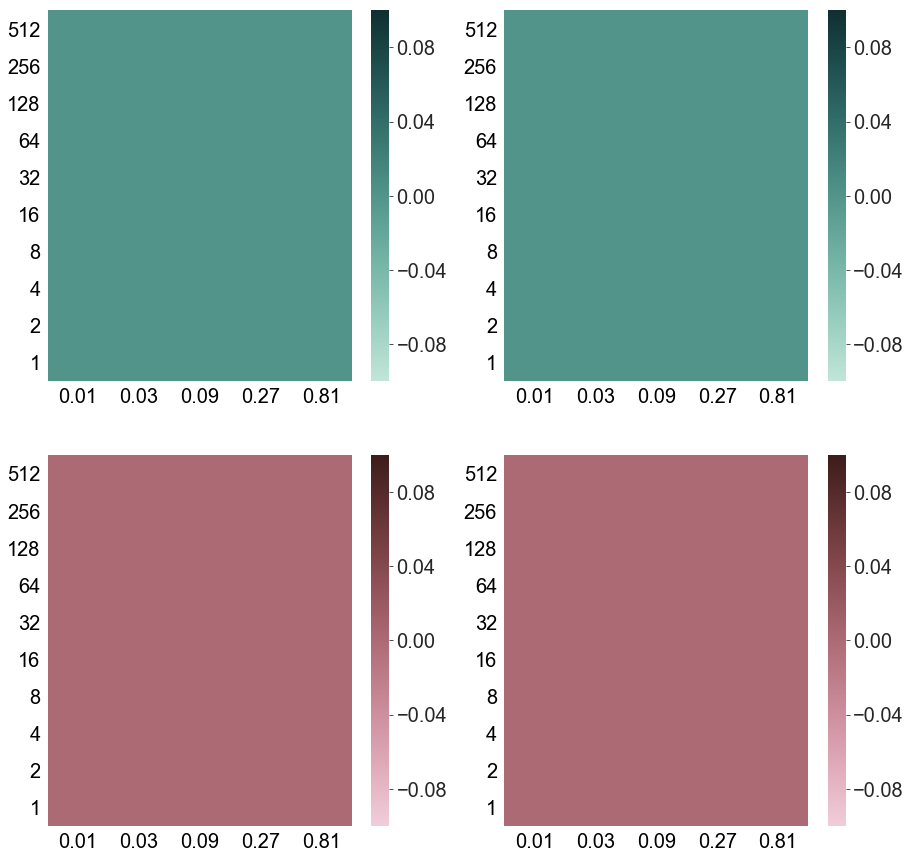

In [23]:
# plotting
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
cm1 = cubehelix_palette(n_colors=int(len(n_jrcs)*len(p_conn)), as_cmap=True, start=2.5, rot=-0.1)
cm2 = cubehelix_palette(n_colors=int(len(n_jrcs)*len(p_conn)), as_cmap=True, start=-2.0, rot=-0.1)
plot_connectivity(sim_times[:, :, 0], ax=axes[0, 0], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm1)
axes[0, 0].set_yticklabels(axes[0, 0].get_yticklabels(), rotation='horizontal')
plot_connectivity(sim_times[:, :, 1], ax=axes[0, 1], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm1)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticklabels(), rotation='horizontal')
plot_connectivity(sim_times[:, :, 2], ax=axes[1, 0], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm2)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticklabels(), rotation='horizontal')
plot_connectivity(sim_times[:, :, 3], ax=axes[1, 1], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm2)
axes[1, 1].set_yticklabels(axes[1, 1].get_yticklabels(), rotation='horizontal')
plt.savefig('PyRates_benchmarks_1.svg', format='svg')
plt.show()